In [287]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [288]:
new_words=pd.read_csv("data/amharic_names.csv")
old_words=open("data/cleaned_words.txt","r").read().splitlines()
new_amh_words=new_words["in_am"].tolist()
am_words=new_amh_words + old_words

In [289]:
chrs=sorted(set(list("".join(am_words))))
stoi={s:i+1 for i,s in enumerate(chrs)}
stoi["."]=0
itos={i:s for s,i in stoi.items()}

In [290]:
block_size=3
def build_dataset(am_words):
    X,Y=[],[]
    for w in am_words:
        context=[0]*block_size
        for ch in w +".":
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(am_words)
n1=int(0.8*(len(am_words)))
n2=int(0.9*(len(am_words)))

Xtr,Ytr=build_dataset(am_words[:n1])      #80
Xval,Yval=build_dataset(am_words[n1:n2])  #10
Xte,Yte=build_dataset(am_words[n2:])      #10

In [291]:
g=torch.Generator().manual_seed(2147483647)
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5   # batch normalization
        self.bias=torch.zeros(fan_out) if bias else None 
    def __call__(self,x):
        self.out=x @ self.weight
        if self.bias is not None:
            self.out +=self.bias
        return self.out 
    def parameters(self):
        return[self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        #parameters(train with backprop)
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        #buffers(doesnt use grad trained with a running "momentum update")
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)
    def __call__(self,x):
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_mean
        xhat=(x-xmean)/torch.sqrt(xvar + self.eps) #normalization 
        self.out=self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var= (1-self.momentum)*self.running_var  + self.momentum * xvar
            return self.out       
    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out  
    def parameters(self):
        return []    

In [292]:
n_embed=10
n_hidden=100
block_size=3
vocab_size=len(itos)
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embed),  generator=g)

In [293]:
# 6-layers
layers=[
    Linear(n_embed*block_size, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),BatchNorm1d(vocab_size)
]

In [294]:
with torch.no_grad():
    layers[-1].gamma*=0.1 #last layer make less confident
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*= 5/3  #other layers apply gain
parameters=[C]+[p for layer in layers for p in layer.parameters()] 
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True   

67891


In [ ]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]   #update to data ratio

for i in range(max_steps):
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    embed=C[Xb]
    x=embed.view(embed.shape[0],-1) # concat
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()

    lr=0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+=-lr * p.grad

    #track the stats

    if i%10000==0:
        print(f"{i: 7d}/{max_steps: 6d}  {loss.item(): 4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/(lr*p.data).std()).log10().item() for p in parameters])

layer 2 (      Tanh): mean -0.01, std 0.62, saturated: 3.72%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.34%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 3.22%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.62%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.94%


Text(0.5, 1.0, 'activation distribution')

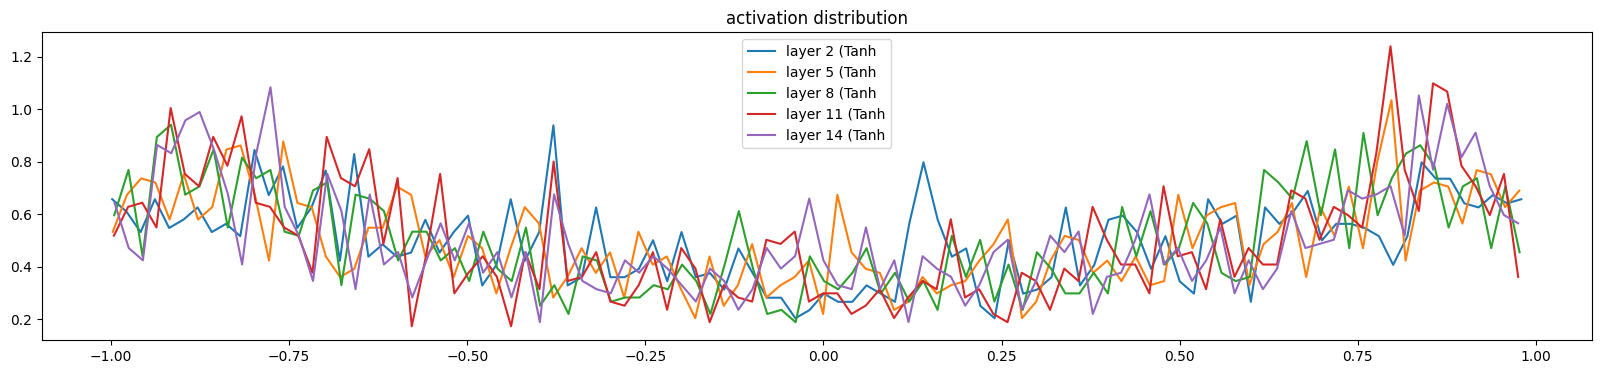

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.285068e-03
layer 5 (      Tanh): mean +0.000000, std 3.887333e-03
layer 8 (      Tanh): mean -0.000000, std 3.478685e-03
layer 11 (      Tanh): mean +0.000000, std 3.302369e-03
layer 14 (      Tanh): mean -0.000000, std 2.839684e-03


Text(0.5, 1.0, 'gradient distribution')

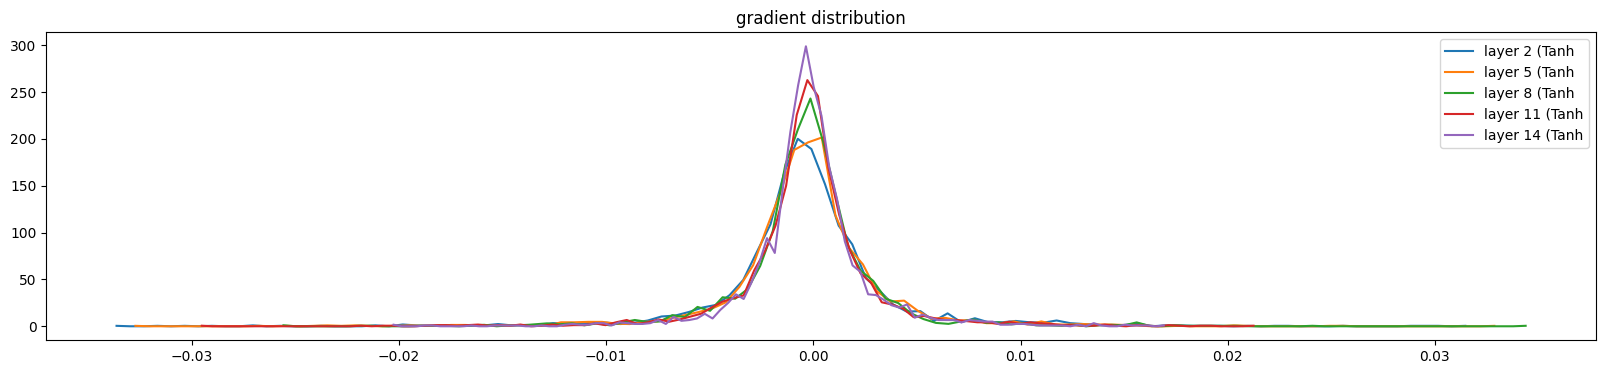

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight  (207, 10) | mean -0.000000 | std 4.257426e-03 | grad:data ratio 4.269181e-03
weight  (30, 100) | mean -0.000356 | std 1.006882e-02 | grad:data ratio 3.317336e-02
weight (100, 100) | mean -0.000105 | std 8.708654e-03 | grad:data ratio 5.174148e-02
weight (100, 100) | mean -0.000018 | std 7.566242e-03 | grad:data ratio 4.543111e-02
weight (100, 100) | mean -0.000028 | std 6.817415e-03 | grad:data ratio 4.088684e-02
weight (100, 100) | mean -0.000195 | std 6.001306e-03 | grad:data ratio 3.562583e-02
weight (100, 207) | mean -0.000011 | std 3.546704e-03 | grad:data ratio 2.124645e-02


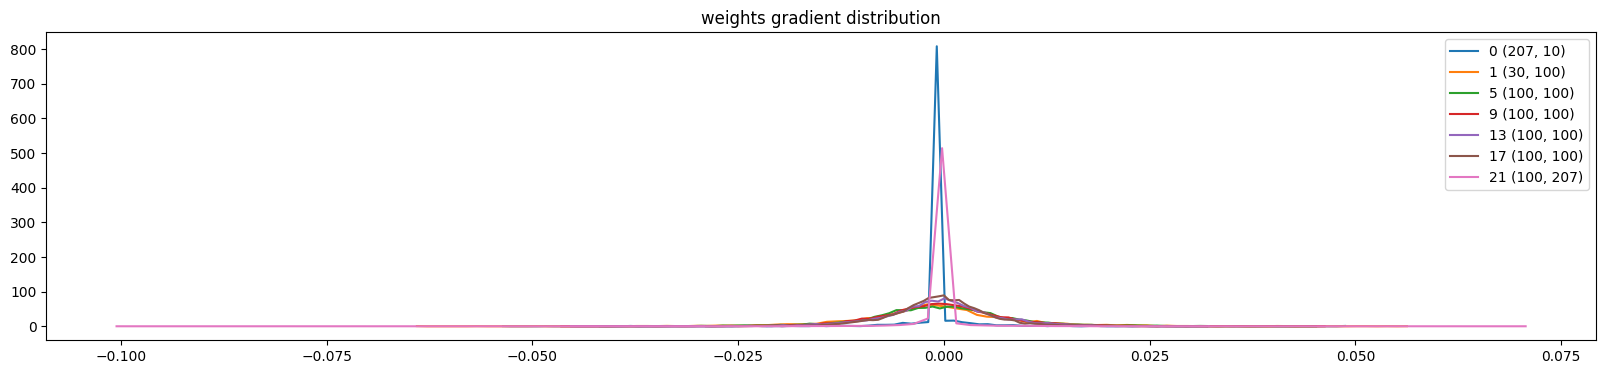

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

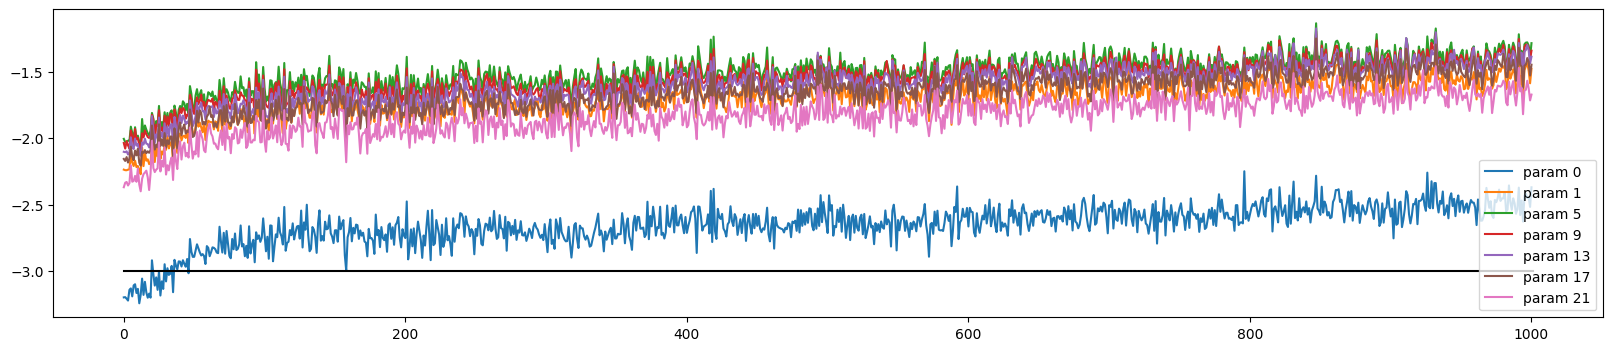

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);